Error setting GPU memory configuration: Virtual devices cannot be modified after being initialized
Loaded 13233 images from 5749 classes.
Epoch 1/5
1324/1324 [==============================] - 99s 73ms/step - loss: 12.4771 - accuracy: 0.1297 - val_loss: 11.7980 - val_accuracy: 0.1806
Epoch 2/5
1324/1324 [==============================] - 99s 75ms/step - loss: 11.0921 - accuracy: 0.2045 - val_loss: 11.6896 - val_accuracy: 0.1938
Epoch 3/5
1324/1324 [==============================] - 101s 76ms/step - loss: 10.4122 - accuracy: 0.2308 - val_loss: 11.4748 - val_accuracy: 0.2221
Epoch 4/5
1324/1324 [==============================] - 115s 87ms/step - loss: 9.9313 - accuracy: 0.2474 - val_loss: 11.4824 - val_accuracy: 0.2244
Epoch 5/5
331/331 [==============================] - 22s 65ms/step - loss: 11.3638 - accuracy: 0.2433
Test Loss: 11.3638, Test Accuracy: 24.33%


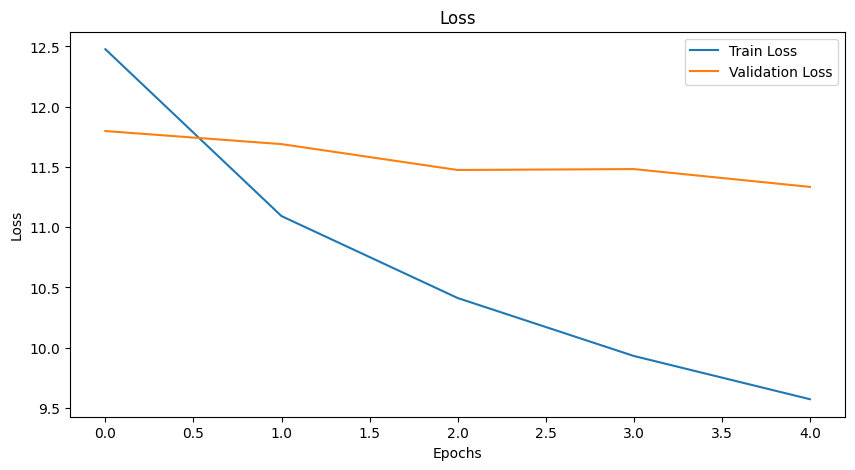

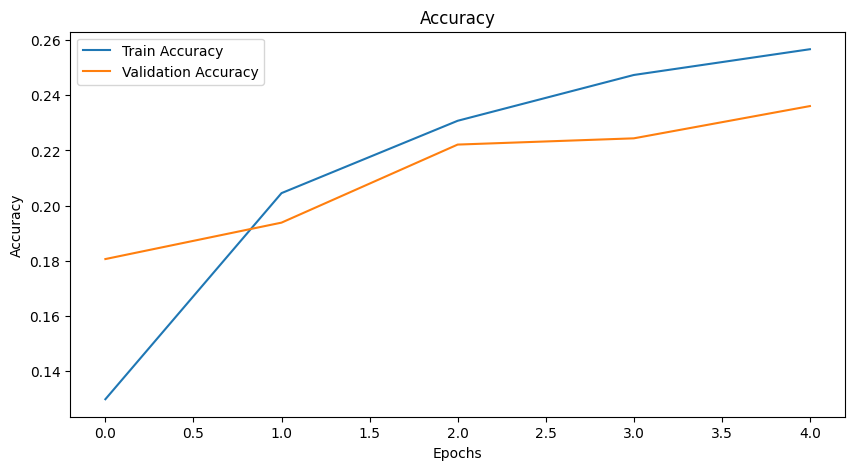

331/331 [==============================] - 13s 40ms/step


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [9]:
import os
import numpy as np
import tensorflow as tf
from keras_vggface.vggface import VGGFace
from keras_vggface import utils
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Enable GPU memory growth and limit memory usage
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            # Optional: Limit memory usage to 4GB
            tf.config.set_logical_device_configuration(
                gpu, [tf.config.LogicalDeviceConfiguration(memory_limit=4096)]
            )
    except RuntimeError as e:
        print("Error setting GPU memory configuration:", e)

# Dataset loading function
def load_dataset_vggface(data_dir, target_size=(224, 224), subset_size=None):
    images, labels, class_names = [], [], []
    for idx, person_name in enumerate(os.listdir(data_dir)):
        person_dir = os.path.join(data_dir, person_name)
        if not os.path.isdir(person_dir):
            continue
        class_names.append(person_name)
        for img_name in os.listdir(person_dir):
            img_path = os.path.join(person_dir, img_name)
            if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue
            try:
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                img_array = utils.preprocess_input(img_array, version=1)
                images.append(img_array)
                labels.append(idx)
                if subset_size and len(images) >= subset_size:
                    break
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
        if subset_size and len(images) >= subset_size:
            break
    return np.array(images), np.array(labels), class_names

# Paths
data_dir = r'C:\Users\Alpha\Desktop\Project in secure ML\dataset\lfw-deepfunneled\lfw-deepfunneled'

# Debugging option: Use a subset of the data
subset_size = None  # Set to a smaller number (e.g., 1000) for debugging

# Load dataset
images, labels, class_names = load_dataset_vggface(data_dir, subset_size=subset_size)
print(f"Loaded {len(images)} images from {len(class_names)} classes.")

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(class_names))
y_test = tf.keras.utils.to_categorical(y_test, num_classes=len(class_names))

# Use data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    preprocessing_function=utils.preprocess_input
)
train_gen = datagen.flow(X_train, y_train, batch_size=8)
test_gen = datagen.flow(X_test, y_test, batch_size=8)

# Load the VGGFace model
image_input = Input(shape=(224, 224, 3))
vggface_model = VGGFace(input_tensor=image_input, include_top=True, weights='vggface')

# Customize the top layer
last_layer = vggface_model.get_layer('fc8').output
output_layer = Dense(len(class_names), activation='softmax', name='output')(last_layer)

# Build the new model
custom_vgg_model = Model(inputs=image_input, outputs=output_layer)

# Freeze all layers except the classification head
for layer in custom_vgg_model.layers[:-1]:
    layer.trainable = False

# Compile the model
custom_vgg_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(learning_rate=0.0001), metrics=['accuracy'])

# Train the model
history = custom_vgg_model.fit(
    train_gen,
    epochs=5,
    validation_data=test_gen,
    verbose=1
)

# Evaluate the model
loss, accuracy = custom_vgg_model.evaluate(test_gen, verbose=1)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%")

# Plot training and validation loss/accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

# Biometric Identification
feature_extractor = Model(inputs=custom_vgg_model.input, outputs=custom_vgg_model.get_layer('fc7').output)
embeddings_test = feature_extractor.predict(X_test, batch_size=8)
embeddings_train = feature_extractor.predict(X_train, batch_size=8)

# Compute cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
similarity_scores = cosine_similarity(embeddings_test, embeddings_train)
top_matches = np.argmax(similarity_scores, axis=1)

# Accuracy of biometric identification
biometric_accuracy = np.mean(top_matches == np.argmax(y_test, axis=1))
print(f"Biometric Identification Accuracy: {biometric_accuracy * 100:.2f}%")
